http://www.cs.cmu.edu/~ark/personas/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MultiLabelBinarizer
%config InlineBackend.figure_format = 'retina'

In [2]:
genres = pd.read_csv(
    'data/raw/movie.metadata.tsv',
    converters={'genres': lambda x: list(eval(x).values())},
    delimiter='\t',
    header=None,
    index_col='id',
    names=['id', 'genres'],
    usecols=[0, 8])

summaries = pd.read_csv(
    'data/raw/plot_summaries.txt',
    delimiter='\t',
    header=None,
    index_col='id',
    names=['id', 'summary'])

df = summaries.merge(genres, on='id').reset_index(drop=True)
mlb = MultiLabelBinarizer()
labels = pd.DataFrame(mlb.fit_transform(df.genres), columns=mlb.classes_)
X, Y = df[['summary']], labels[labels.sum().nlargest(10).sort_index().index]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=10000, random_state=0)

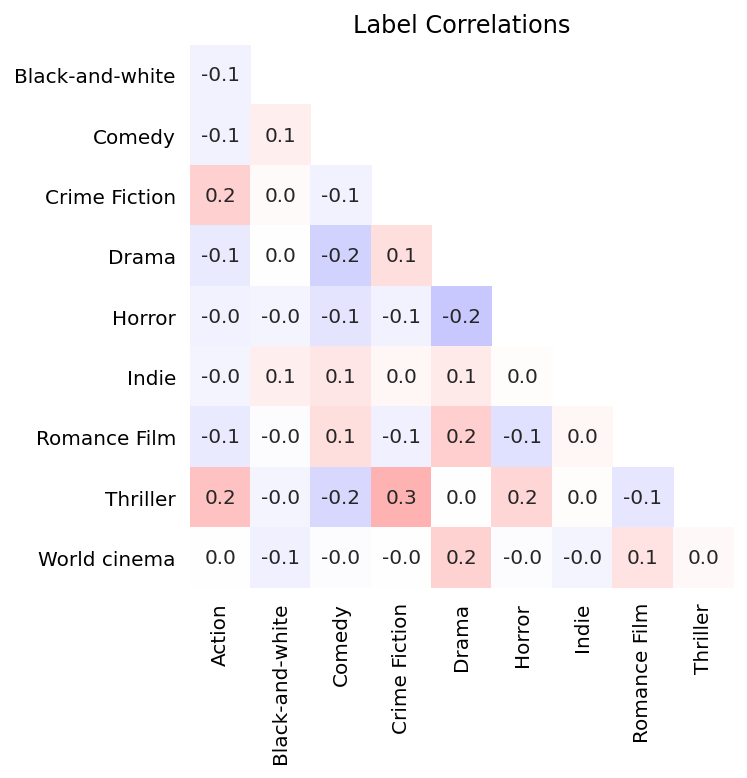

In [3]:
label_corr = Y_train.corr().iloc[1:, :-1]
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(
    label_corr,
    annot=True,
    ax=ax,
    cbar=False,
    cmap='bwr',
    fmt='.1f',
    mask=np.triu(np.ones_like(label_corr), k=1),
    square=True,
    vmax=1,
    vmin=-1)
ax.set(title='Label Correlations')
ax.tick_params(left=False, bottom=False)

In [4]:
model = make_pipeline(
    make_column_transformer((TfidfVectorizer(), 'summary')),
    MultiOutputClassifier(LogisticRegression(solver='liblinear', random_state=0), n_jobs=-1)
).fit(X_train, Y_train)

In [5]:
def evaluate(model, X, Y_true):
    Y_pred = model.predict(X)
    return pd.Series({
        'Subset accuracy': accuracy_score(Y_true, Y_pred),
        'Accuracy': jaccard_score(Y_true, Y_pred, average='samples', zero_division=1),
        'Hamming similarity': hamming_loss(Y_true, Y_pred),
        'Precision': precision_score(Y_true, Y_pred, average='samples', zero_division=1),
        'Recall': recall_score(Y_true, Y_pred, average='samples', zero_division=1),
        'F1': f1_score(Y_true, Y_pred, average='samples', zero_division=1),
    })

In [6]:
evaluate(model, X_train, Y_train)

Subset accuracy       0.340796
Accuracy              0.491843
Hamming similarity    0.109530
Precision             0.911217
Recall                0.537379
F1                    0.546226
dtype: float64